# This practice will cover learning points in class2
### 1 - Fit MLR model in python with sklearn and statesmodel packages
### 2 - Model Selection
### 3 - Weighted regression
### 4 - Regularization, L1 and L2

Import required Python packages.

In [6]:
from pathlib import Path
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

%matplotlib inline

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [7]:
DATA = Path('.').resolve().parents[1] / 'Practice\mlr'

HOUSE_CSV = DATA / 'house_sales.csv'

In [8]:
print(DATA)

print(HOUSE_CSV)

C:\Users\johnn\Desktop\github\DataScienceProgram\Class2\Practice\mlr
C:\Users\johnn\Desktop\github\DataScienceProgram\Class2\Practice\mlr\house_sales.csv


#### Data read and train-test split

In [9]:
houseall = pd.read_csv(HOUSE_CSV, sep='\t')

house, house_test = train_test_split(houseall, test_size=0.2)

print(house.head())
print(house.shape)

print(house_test.head())
print(house_test.shape)

      DocumentDate  SalePrice  PropertyID   PropertyType          ym  zhvi_px  \
21624   2006-11-03     408265  7853300660  Single Family  2006-11-01   421200   
21139   2006-02-27     780000  7774200210  Single Family  2006-02-01   387600   
16682   2015-04-10     330000  5634500392  Single Family  2015-04-01   429900   
18279   2013-08-23     624900  6681500080  Single Family  2013-08-01   374300   
15412   2011-12-26     217000  5104510190  Single Family  2011-12-01   311900   

       zhvi_idx  AdjSalePrice  NbrLivingUnits  SqFtLot  ...  Bathrooms  \
21624  0.967831      421835.0               1     4400  ...        2.5   
21139  0.890625      875789.0               1    16888  ...        2.5   
16682  0.987822      334068.0               1    13959  ...        3.0   
18279  0.860064      726574.0               1     4800  ...        2.0   
15412  0.716682      302784.0               1     4694  ...        2.5   

       Bedrooms  BldgGrade  YrBuilt  YrRenovated  TrafficNoise  Land

We can use the `LinearRegression` model from _scikit-learn_.

## 1 - Multiple Linear Regression (SKlearn)

In [10]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
          'Bedrooms', 'BldgGrade']

print(house[subset].head())

       AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
21624      421835.0           1960     4400        2.5         3          7
21139      875789.0           3290    16888        2.5         4         10
16682      334068.0           2420    13959        3.0         3          8
18279      726574.0           2230     4800        2.0         3          7
15412      302784.0           1830     4694        2.5         4          7


In [11]:
print(house.head())
print(house.columns)

      DocumentDate  SalePrice  PropertyID   PropertyType          ym  zhvi_px  \
21624   2006-11-03     408265  7853300660  Single Family  2006-11-01   421200   
21139   2006-02-27     780000  7774200210  Single Family  2006-02-01   387600   
16682   2015-04-10     330000  5634500392  Single Family  2015-04-01   429900   
18279   2013-08-23     624900  6681500080  Single Family  2013-08-01   374300   
15412   2011-12-26     217000  5104510190  Single Family  2011-12-01   311900   

       zhvi_idx  AdjSalePrice  NbrLivingUnits  SqFtLot  ...  Bathrooms  \
21624  0.967831      421835.0               1     4400  ...        2.5   
21139  0.890625      875789.0               1    16888  ...        2.5   
16682  0.987822      334068.0               1    13959  ...        3.0   
18279  0.860064      726574.0               1     4800  ...        2.0   
15412  0.716682      302784.0               1     4694  ...        2.5   

       Bedrooms  BldgGrade  YrBuilt  YrRenovated  TrafficNoise  Land

In [12]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

print(f'Intercept: {house_lm.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors, house_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -489408.137
Coefficients:
 SqFtTotLiving: 238.7382616652007
 SqFtLot: -0.0679168843235053
 Bathrooms: -18377.232584562866
 Bedrooms: -54038.50975203022
 BldgGrade: 101749.08972266875


### Assessing the Model with performance KPIs
_Scikit-learn_ provides a number of metrics to determine the quality of a model. Here we use the `r2_score` and `RMSE`.

In [13]:
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0f}')
print(f'r2: {r2:.4f}')

fitted_test = house_lm.predict(house_test[predictors])
RMSE_test = np.sqrt(mean_squared_error(house_test[outcome], fitted_test))
r2_test = r2_score(house_test[outcome], fitted_test)
print(f'RMSE_test: {RMSE_test:.0f}')
print(f'r2_test: {r2_test:.4f}')

RMSE: 263537
r2: 0.5408
RMSE_test: 252041
r2_test: 0.5385


## 1 - Multiple Linear Regression (statsmodels)

While _scikit-learn_ provides a variety of different metrics, _statsmodels_ provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to _scikit-learn_ and one that allows specifying _R_-style formulas. Here we use the first approach. As _statsmodels_ doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the _pandas_ method assign for this.

In [14]:
mlr_sm = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = mlr_sm.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     4273.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        22:40:12   Log-Likelihood:            -2.5229e+05
No. Observations:               18149   AIC:                         5.046e+05
Df Residuals:                   18143   BIC:                         5.046e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   238.7383      4.424     53.960

### Correlations between predictors

Correlation Matrix 
                SqFtTotLiving   SqFtLot  Bathrooms  Bedrooms  BldgGrade
SqFtTotLiving       1.000000  0.198984   0.765443  0.613406   0.769775
SqFtLot             0.198984  1.000000   0.107266  0.070775   0.144034
Bathrooms           0.765443  0.107266   1.000000  0.551266   0.656486
Bedrooms            0.613406  0.070775   0.551266  1.000000   0.373842
BldgGrade           0.769775  0.144034   0.656486  0.373842   1.000000


[Text(0.5, 0, 'SqFtTotLiving'),
 Text(1.5, 0, 'SqFtLot'),
 Text(2.5, 0, 'Bathrooms'),
 Text(3.5, 0, 'Bedrooms'),
 Text(4.5, 0, 'BldgGrade')]

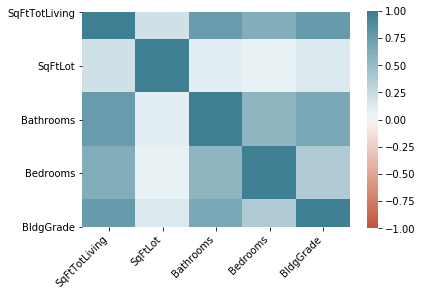

In [15]:
corr = house[predictors].corr()
print("Correlation Matrix \n {}".format(corr))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

## 2 - Model Selection and Stepwise Regression

In [16]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

print(house[predictors].head())

print("\n PropertyType List \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

print("\nPredictors after nominal varibale(s) treatment: {} \n\n".format(X.shape))

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())

       SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade   PropertyType  \
21624           1960     4400        2.5         3          7  Single Family   
21139           3290    16888        2.5         4         10  Single Family   
16682           2420    13959        3.0         3          8  Single Family   
18279           2230     4800        2.0         3          7  Single Family   
15412           1830     4694        2.5         4          7  Single Family   

       NbrLivingUnits  SqFtFinBasement  YrBuilt  YrRenovated  NewConstruction  
21624               1                0     2006            0             True  
21139               1             1190     1991            0            False  
16682               1              680     1988            0            False  
18279               1              940     1915            0            False  
15412               1                0     2003            0            False  

 PropertyType List 
Single Family    1

We can use the `stepwise_selection` method from the _dmba_ package.

In [ ]:
y = house[outcome]

def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, 
                                                verbose=True)

print()
print(f'Intercept: {best_model.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(best_variables, best_model.coef_):
    print(f' {name}: {coef}')

## 3 - Weighted regression
For the house data recent sale price is more relavent for future prediction, old sale data is less reliable, therefore, we like to emphasis the recent sale data by apply more weight. We will use year the house sale to 2005 as weight.

We can calculate the Year from the date column using either a list comprehension or the data frame's `apply` method.

In [15]:
print("\nDocumentDate List \n{}".format(house['DocumentDate'].value_counts(dropna=False)))


DocumentDate List 
2006-06-28    48
2006-07-26    48
2006-05-30    45
2006-08-24    44
2006-06-01    44
              ..
2015-05-19     1
2011-12-07     1
2014-12-05     1
2012-02-16     1
2006-08-20     1
Name: DocumentDate, Length: 2461, dtype: int64


In [16]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]  #list comprehension
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))  # apply()
house['Weight'] = house.Year - 2005

C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [17]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)
pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept', 
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)

,predictor,house_lm,house_wt
0,SqFtTotLiving,233.988942,251.507898
1,SqFtLot,-0.079342,-0.320387
2,Bathrooms,-19710.315740,-27396.580318
3,Bedrooms,-48910.813239,-56081.766475
4,BldgGrade,104511.739187,112102.144966
5,intercept,-515622.529004,-562309.653883


       abs_residual_lm  abs_residual_wt  Year
1034     103783.669942    117725.486644  2010
3707      43257.186237     54386.087149  2007
25811    252378.874708    244581.529713  2008
1781       9144.393294      3234.484919  2008
25059    206912.697855    220297.318954  2006


Year   Abs_residual_lm    Abs_residual_wt
2006 140615.44627184205 146075.23269855397
2007 149644.77632330862 154564.0512862004
2008 144142.05445190886 148022.25129591255
2009 147838.35168361152 151530.1072899237
2010 165850.31372002384 168394.79604033942
2011 175127.67318058238 177277.46145572016
2012 166698.9682081134 168952.9549059125
2013 200126.84975968086 202463.684709197
2014 188033.3282023555 189693.43218758836
2015 185724.71915086126 183781.2482448893


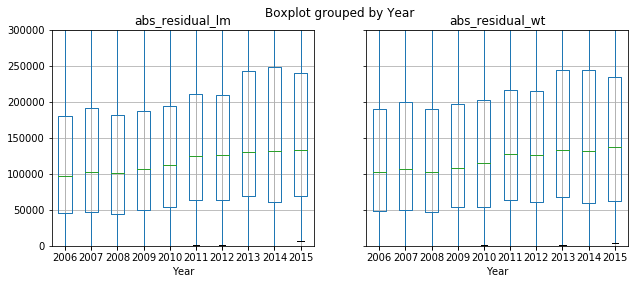

In [18]:
residuals = pd.DataFrame({
    'abs_residual_lm': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual_wt': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
axes = residuals.boxplot(['abs_residual_lm', 'abs_residual_wt'], by='Year', figsize=(10, 4))
axes[0].set_ylim(0, 300000)

print("\n\nYear   Abs_residual_lm    Abs_residual_wt")
for year, group in residuals.groupby('Year'):
    print(year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt']))

Seems only help 2015 prediction reduce the residuale.If we have a recent holdout sample we can test the weight could help for furture prediction or not

# 4 - Regularization

In [45]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

outcome = 'AdjSalePrice'

print(house[predictors].head())

print("\n PropertyType List \n{}".format(house['PropertyType'].value_counts(dropna=False)))

X_train = pd.get_dummies(house[predictors], drop_first=True)
X_train['NewConstruction'] = [1 if nc else 0 for nc in X_train['NewConstruction']]
y_train = house[outcome]

X_test = pd.get_dummies(house_test[predictors], drop_first=True)
X_test['NewConstruction'] = [1 if nc else 0 for nc in X_test['NewConstruction']]
y_test = house_test[outcome]

       SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade   PropertyType  \
21624           1960     4400        2.5         3          7  Single Family   
21139           3290    16888        2.5         4         10  Single Family   
16682           2420    13959        3.0         3          8  Single Family   
18279           2230     4800        2.0         3          7  Single Family   
15412           1830     4694        2.5         4          7  Single Family   

       NbrLivingUnits  SqFtFinBasement  YrBuilt  YrRenovated  NewConstruction  
21624               1                0     2006            0             True  
21139               1             1190     1991            0            False  
16682               1              680     1988            0            False  
18279               1              940     1915            0            False  
15412               1                0     2003            0            False  

 PropertyType List 
Single Family    1

### Regular Multiple Regression

In [46]:
house_lm = LinearRegression()
house_lm.fit(X_train, y_train)

mlr_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((house_lm.intercept_, house_lm.coef_), 
                                axis=None), 3))
)

mlr_coefs

{'Intercept': 6253438.247,
 'SqFtTotLiving': 208.863,
 'SqFtLot': 0.058,
 'Bathrooms': 43956.047,
 'Bedrooms': -57650.812,
 'BldgGrade': 132981.485,
 'NbrLivingUnits': 22840.096,
 'SqFtFinBasement': 3.716,
 'YrBuilt': -3611.898,
 'YrRenovated': -2.519,
 'NewConstruction': -1628.71,
 'PropertyType_Single Family': 46139.123}

In [47]:
fitted_test = house_lm.predict(X_test)
MSE_test = np.sqrt(mean_squared_error(y_test, fitted_test))
r2 = r2_score(y_test, fitted_test)
print(f'regular mlr MSE: {MSE_test:.0f}')
print(f'r2_test: {r2:.4f}')

regular mlr MSE: 236453
r2_test: 0.5938


### L2 - Ridge regression (Parameter shrinkage)

In [48]:
ridge_cv = RidgeCV(normalize=True, alphas=np.logspace(-10, 1, 400))
ridge_model = ridge_cv.fit(X_train, y_train)
ridge_prediction = ridge_model.predict(X_test)
ridge_mae = np.mean(np.abs(y_test - ridge_prediction))
ridge_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((ridge_model.intercept_, ridge_model.coef_), 
                                axis=None), 3))
)

print('Ridge Regression MAE: {}'.format(np.round(ridge_mae, 3)))
print('Ridge Regression coefficients:')
ridge_coefs

Ridge Regression MAE: 136115.592
Ridge Regression coefficients:


{'Intercept': 6158725.175,
 'SqFtTotLiving': 204.852,
 'SqFtLot': 0.069,
 'Bathrooms': 45042.775,
 'Bedrooms': -56311.415,
 'BldgGrade': 133022.374,
 'NbrLivingUnits': 16096.328,
 'SqFtFinBasement': 6.249,
 'YrBuilt': -3553.649,
 'YrRenovated': -1.59,
 'NewConstruction': -1584.415,
 'PropertyType_Single Family': 33225.841}

### L1 - Lasso regression (Parameter sparsity)

In [49]:
lasso_cv = LassoCV(normalize=True, alphas=np.logspace(-10, 1, 400))
lasso_model = lasso_cv.fit(X_train, y_train)
lasso_prediction = lasso_model.predict(X_test)
lasso_mae = np.mean(np.abs(y_test - lasso_prediction))
lasso_coefs = dict(
    zip(['Intercept'] + X_train.columns.tolist()[:-1], 
        np.round(np.concatenate((lasso_model.intercept_, lasso_model.coef_), axis=None), 3))
)

print('LASSO MAE: {}'.format(np.round(lasso_mae, 3)))
print('LASSO coefficients:')
lasso_coefs

LASSO MAE: 135875.408
LASSO coefficients:


{'Intercept': 6068917.341,
 'SqFtTotLiving': 206.204,
 'SqFtLot': 0.021,
 'Bathrooms': 40385.757,
 'Bedrooms': -53749.693,
 'BldgGrade': 132606.009,
 'NbrLivingUnits': 0.0,
 'SqFtFinBasement': 3.776,
 'YrBuilt': -3481.479,
 'YrRenovated': 0.0,
 'NewConstruction': -0.0,
 'PropertyType_Single Family': -0.0}

# Home Work

1. Compare the three model fits and draw conclusion 
from the comparision of the three model firt regarding there coefficent difference

In [50]:
print('MLR')
print(mlr_coefs)
print('RIDGE')
print(ridge_coefs)
print('LASSO')
print(lasso_coefs)

MLR
{'Intercept': 6253438.247, 'SqFtTotLiving': 208.863, 'SqFtLot': 0.058, 'Bathrooms': 43956.047, 'Bedrooms': -57650.812, 'BldgGrade': 132981.485, 'NbrLivingUnits': 22840.096, 'SqFtFinBasement': 3.716, 'YrBuilt': -3611.898, 'YrRenovated': -2.519, 'NewConstruction': -1628.71, 'PropertyType_Single Family': 46139.123}
RIDGE
{'Intercept': 6158725.175, 'SqFtTotLiving': 204.852, 'SqFtLot': 0.069, 'Bathrooms': 45042.775, 'Bedrooms': -56311.415, 'BldgGrade': 133022.374, 'NbrLivingUnits': 16096.328, 'SqFtFinBasement': 6.249, 'YrBuilt': -3553.649, 'YrRenovated': -1.59, 'NewConstruction': -1584.415, 'PropertyType_Single Family': 33225.841}
LASSO
{'Intercept': 6068917.341, 'SqFtTotLiving': 206.204, 'SqFtLot': 0.021, 'Bathrooms': 40385.757, 'Bedrooms': -53749.693, 'BldgGrade': 132606.009, 'NbrLivingUnits': 0.0, 'SqFtFinBasement': 3.776, 'YrBuilt': -3481.479, 'YrRenovated': 0.0, 'NewConstruction': -0.0, 'PropertyType_Single Family': -0.0}


####  The difference between ridge and lasso regression is that Lasso tends to make coefficients to absolute zero as compared to Ridge which doesn't set the value of coefficient to absolute zero but tring to minimize them and the total number of predictors didn't change. In Lasso Regression, the coefficents of "YrRenovated" and "Family", 'NbrLivingUnits', 'NewConstruction' are 0. 

2. Show the three model performance on both tran and test

In [51]:
#For train data
fitted_train = house_lm.predict(X_train)
MSE_train = mean_squared_error(y_train, fitted_train)
r2 = r2_score(y_train, fitted_train)

ridge_train_prediction = ridge_model.predict(X_train)
lasso_train_prediction = lasso_model.predict(X_train)

L2_MSE_train = mean_squared_error(y_train, ridge_train_prediction)
L2_train_r2 = r2_score(y_train, ridge_train_prediction)

L1_MSE_train = mean_squared_error(y_train, lasso_train_prediction)                   
L1_train_r2 = r2_score(y_train, lasso_train_prediction)

print(f'regular mlr MSE: {MSE_train:.0f}')
print(f'L2 MSE: {L2_MSE_train:.0f}')
print(f'L1 MSE: {L1_MSE_train:.0f}')

print(f'r2_train: {r2:.4f}')
print(f'L2 r2_train: {L2_train_r2:.4f}')
print(f'L1 r2_train: {L1_train_r2:.4f}')

regular mlr MSE: 61334064361
L2 MSE: 61339881044
L1 MSE: 61364676319
r2_train: 0.5945
L2 r2_train: 0.5944
L1 r2_train: 0.5943


In [52]:
#For test data
fitted_test = house_lm.predict(X_test)
MSE_test = mean_squared_error(y_test, fitted_test)
r2 = r2_score(y_test, fitted_test)

ridge_test_prediction = ridge_model.predict(X_test)
lasso_test_prediction = lasso_model.predict(X_test)

L2_MSE_test = mean_squared_error(y_test, ridge_test_prediction)
L2_r2 = r2_score(y_test, ridge_test_prediction)

L1_MSE_test = mean_squared_error(y_test, lasso_test_prediction)                    
L1_r2 = r2_score(y_test, lasso_test_prediction)

print(f'regular mlr MSE: {MSE_test:.0f}')
print(f'L2 MSE: {L2_MSE_test:.0f}')
print(f'L1 MSE: {L1_MSE_test:.0f}')

print(f'r2_test: {r2:.4f}')
print(f'L2 r2_test: {L2_r2:.4f}')
print(f'L1 r2_test: {L1_r2:.4f}')

regular mlr MSE: 55910181991
L2 MSE: 55828890554
L1 MSE: 55777784546
r2_test: 0.5938
L2 r2_test: 0.5944
L1 r2_test: 0.5947


#### From the result, we can see that these 3 results are pretty close to each other, so it's hard to tell which one is better.